![alt text](https://drive.google.com/uc?export=view&id=1UXScsVx_Wni_JuDdB8LeTnM6jsPfIwkW)

Proprietary content. © Great Learning. All Rights Reserved. Unauthorized use or distribution prohibited.

# Face Mask Prediction using U-Net
Task is to predict the mask around the face in a given image.

# Instructions
- Some part of the code is already done for you
- You need to execute all the cells
- You need to add the code where ever you see `"#### Add your code here ####"`
- Marks are mentioned along with the cells

## Dataset
Faces in images marked with bounding boxes. Have around 409 images with around 1000 faces manually tagged via bounding box.
- Data file name: images.npy

### Mount Google drive if you are using google colab
- We recommend using Google Colab as you can face memory issues and longer runtimes while running on local

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.applications.mobilenet import preprocess_input
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Reshape, UpSampling2D, Concatenate, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

### Load the "images.npy" file (2 marks)
- This file contains images with details of bounding boxes

In [ ]:
data = np.load('/content/drive/MyDrive/Advanced Computer Vision/ACV-Project-1 Datatset/images.npy', allow_pickle=True)

### Check one sample from the loaded "images.npy" file  (2 marks)
- Hint: print data[10][1] 

In [ ]:
print(data[10][1])

[{'label': ['Face'], 'notes': '', 'points': [{'x': 0.48, 'y': 0.10385756676557864}, {'x': 0.7716666666666666, 'y': 0.6795252225519288}], 'imageWidth': 600, 'imageHeight': 337}]


In [ ]:
print(data[351][0])

[[[170 174 173]
  [172 174 173]
  [173 173 173]
  ...
  [242 246 245]
  [242 246 245]
  [242 246 245]]

 [[170 174 173]
  [171 173 172]
  [172 172 172]
  ...
  [243 247 246]
  [243 247 246]
  [244 248 247]]

 [[169 173 172]
  [171 173 172]
  [172 172 172]
  ...
  [245 249 248]
  [246 250 249]
  [247 251 250]]

 ...

 [[225 229 230]
  [225 229 230]
  [226 230 231]
  ...
  [228 227 223]
  [226 225 221]
  [224 223 219]]

 [[225 229 230]
  [226 230 231]
  [227 231 232]
  ...
  [226 225 221]
  [224 223 219]
  [222 221 217]]

 [[225 229 230]
  [226 230 231]
  [228 232 233]
  ...
  [225 224 220]
  [223 222 218]
  [221 220 216]]]


In [ ]:
print(data[351][1])

[{'label': ['Face'], 'notes': '', 'points': [{'x': 0.4132029339853301, 'y': 0.050724637681159424}, {'x': 0.7318663406682967, 'y': 0.8115942028985508}], 'imageWidth': 1280, 'imageHeight': 720}]


In [ ]:
data.shape

(409, 2)

### Set image dimensions   (1 mark)
- Initialize image height, image width with value: 224 

In [ ]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

### Create features and labels
- Here feature is the image
- The label is the mask
- Images will be stored in "X" array
- Masks will be stored in "masks" array

In [ ]:
masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

### Split the data into training and testing (2 marks)
- 400 images in training
- 9 images in testing data

In [ ]:
trainX, testX, trainy, testy = train_test_split(X, masks,test_size=9, random_state=42)

Training data

In [ ]:
X_train = trainX
y_train = trainy

Testing data

In [ ]:
X_test = testX
y_test = testy

In [ ]:
print("X train shape - ", X_train.shape)
print("y train shape - ", y_train.shape)
print("X test shape - ", X_test.shape)
print("y test shape - ", y_test.shape)


X train shape -  (400, 224, 224, 3)
y train shape -  (400, 224, 224)
X test shape -  (9, 224, 224, 3)
y test shape -  (9, 224, 224)


### Print a sample training image, image array and its mask (2 marks)

Print the image and image array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 ...

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]]


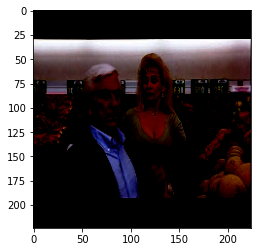

In [ ]:
print(X_train[12])
plt.imshow(X_train[12])
plt.show()

Print the mask

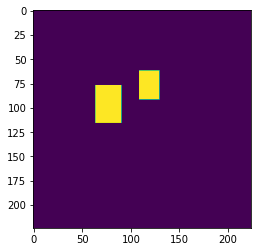

In [ ]:
plt.imshow(y_train[12])
plt.show()


## Create the model (14 marks)
- Add MobileNet as model with below parameter values
  - input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
  - include_top: False
  - alpha: 1.0
  - weights: "imagenet"
- Add UNET architecture layers
  - This is the trickiest part of the project, you need to research and implement it correctly

In [ ]:
HEIGHT_CELLS = 28
WIDTH_CELLS = 28

In [ ]:
def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1.0, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable
  
    block0 = model.get_layer("conv_pw_1_relu").output 
    block = model.get_layer("conv_pw_1_relu").output
    block1 = model.get_layer("conv_pw_3_relu").output
    block2 = model.get_layer("conv_pw_5_relu").output
    block3 = model.get_layer("conv_pw_11_relu").output
    block4 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block4), block3])
    x = Concatenate()([UpSampling2D()(x), block2])
    x = Concatenate()([UpSampling2D()(x), block1])
    x = Concatenate()([UpSampling2D()(x), block])
    x = UpSampling2D()(x)
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)

    x = Reshape((IMAGE_HEIGHT, IMAGE_HEIGHT))(x)

    return Model(inputs=model.input, outputs=x)

### Call the create_model function (4 mark)
- Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)

In [ ]:
model = create_model(False)

### Print model summary (2 mark)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 112, 112, 32) 0           conv1_bn[0][0]                   
______________________________________________________________________________________________

### Define dice coefficient function (4 marks)
- Create a function to calculate dice coefficient


In [ ]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

### Define loss function (4 marks)

In [ ]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

### Compile the model (4 marks)
- Complie the model using below parameters
  - loss: use the loss function defined above
  - optimizers: use Adam optimizer
  - metrics: use dice_coefficient function defined above

In [ ]:
model = create_model()
model.summary()
model.compile(loss=loss, optimizer='adam', metrics=[dice_coefficient])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 112, 112, 32) 0           conv1_bn[0][0]                   
____________________________________________________________________________________________

### Define callbacks (4 marks)
- Use ModelCheckpoint
- Use EarlyStopping
- Use ReduceLROnPlateau

In [ ]:
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True, save_weights_only=True, mode="min", period=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

### Fit the model (5 marks)
- Fit the model using below parameters
  - epochs: you can decide
  - batch_size: 1
  - callbacks: use the callbacks defined above

In [ ]:
model.fit(X_train,y_train,  epochs = 15, validation_data= (X_test ,y_test),verbose=1,batch_size=1,callbacks=[checkpoint,reduce_lr,stop])

Epoch 1/15
400/400 [==============================] - 29s 57ms/step - loss: 1.1860 - dice_coefficient: 0.5156 - val_loss: 1.5644 - val_dice_coefficient: 0.4598

Epoch 00001: loss improved from inf to 1.18602, saving model to model-1.19.h5
Epoch 2/15
400/400 [==============================] - 22s 56ms/step - loss: 0.8648 - dice_coefficient: 0.5970 - val_loss: 1.0129 - val_dice_coefficient: 0.5311

Epoch 00002: loss improved from 1.18602 to 0.86481, saving model to model-0.86.h5
Epoch 3/15
400/400 [==============================] - 23s 57ms/step - loss: 0.7095 - dice_coefficient: 0.6503 - val_loss: 0.8537 - val_dice_coefficient: 0.5654

Epoch 00003: loss improved from 0.86481 to 0.70949, saving model to model-0.71.h5
Epoch 4/15
400/400 [==============================] - 23s 57ms/step - loss: 0.6402 - dice_coefficient: 0.6787 - val_loss: 1.0904 - val_dice_coefficient: 0.5463

Epoch 00004: loss improved from 0.70949 to 0.64018, saving model to model-0.64.h5
Epoch 5/15
400/400 [============

### Get the predicted mask for a test image   (5 marks)

Show the test image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


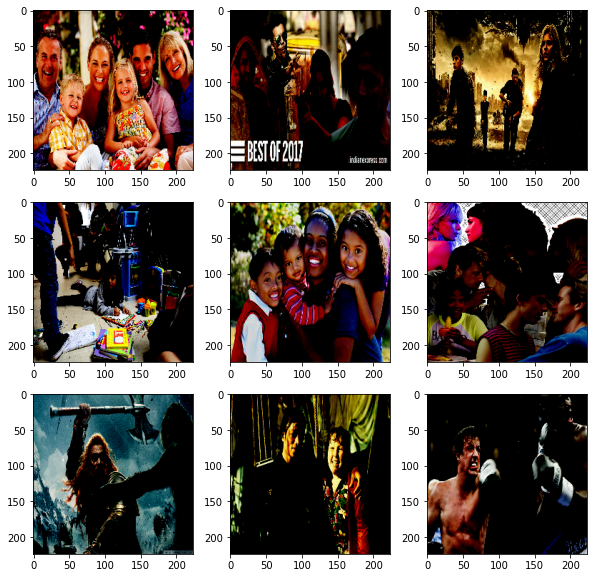

In [ ]:
fig = plt.figure(figsize=(10, 10))

for idx,faces in enumerate(X_test):
  fig.add_subplot(3, 3, idx+1)
  plt.imshow(faces)

Show original mask for test image

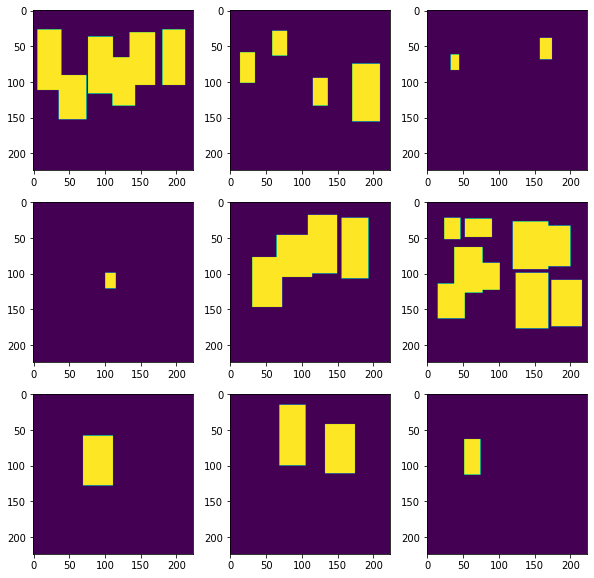

In [ ]:
fig = plt.figure(figsize=(10, 10))

for idx,faces in enumerate(y_test):
  fig.add_subplot(3, 3, idx+1)
  plt.imshow(faces)

Predict the mask on the test image

In [ ]:
def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


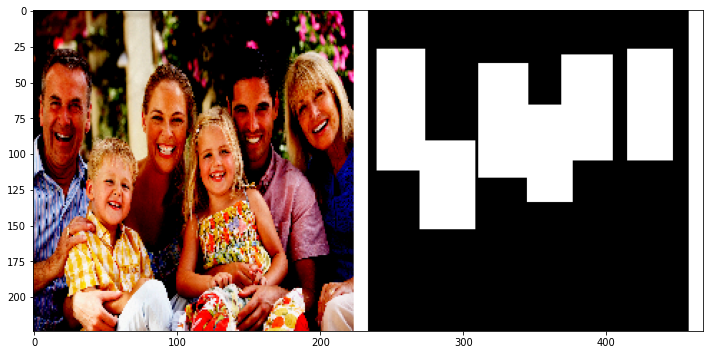

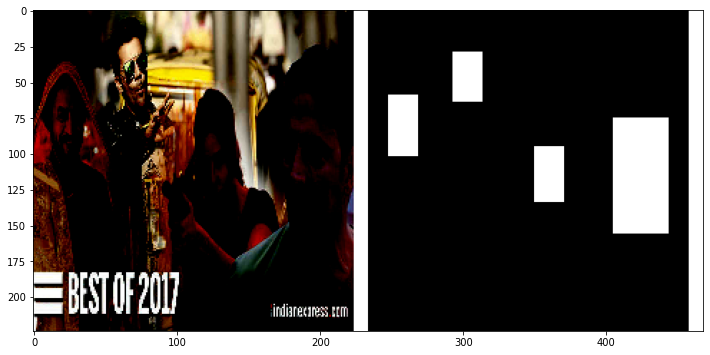

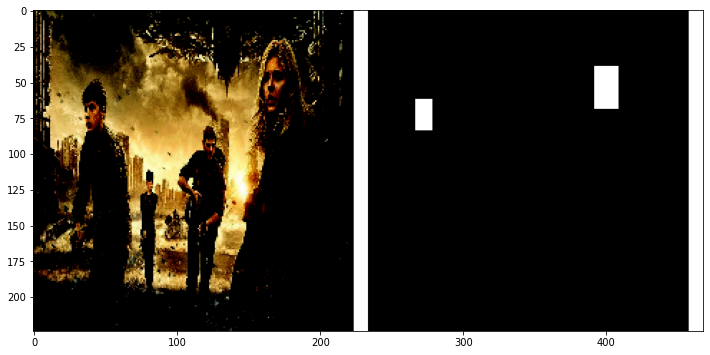

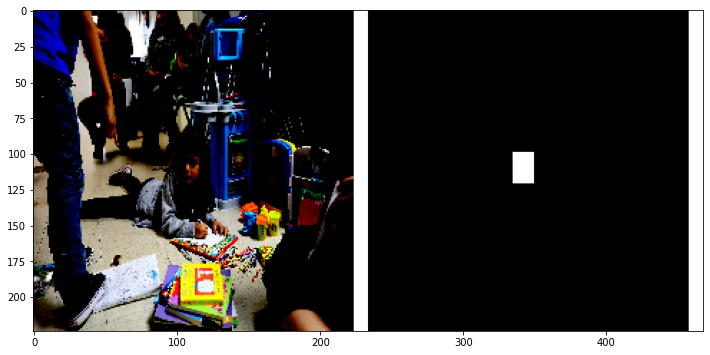

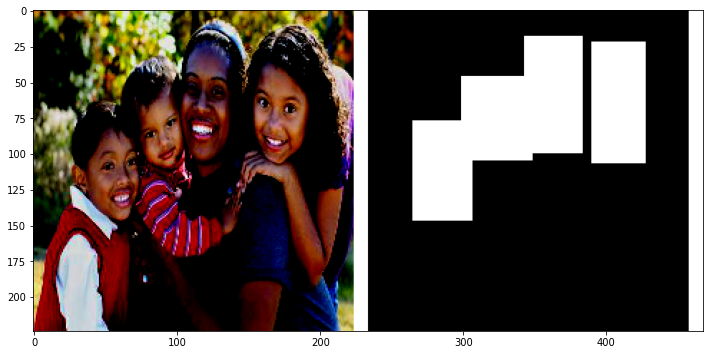

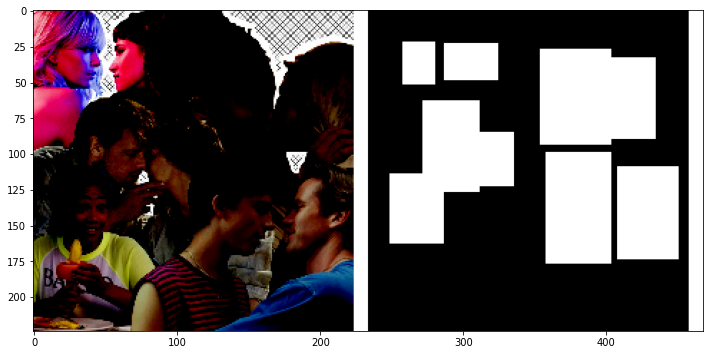

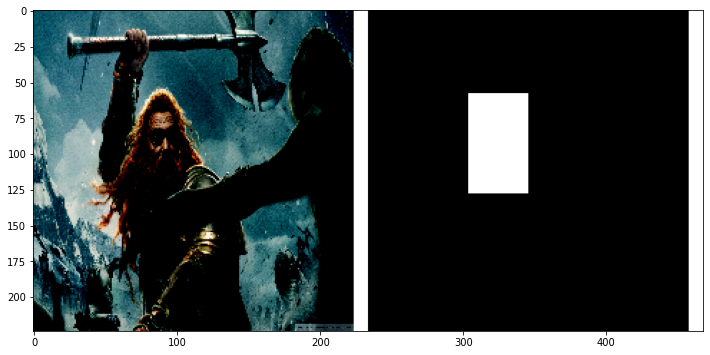

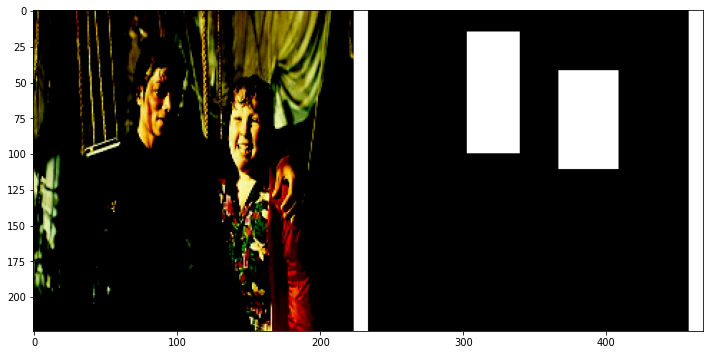

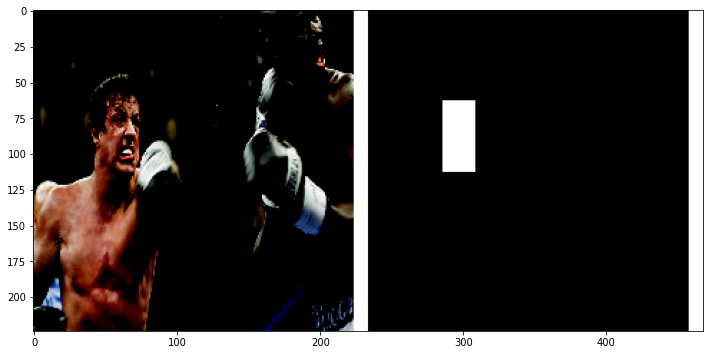

In [ ]:
for i, (x, y) in enumerate(zip(X_test, y_test)):
    y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
    h, w, _ = x.shape
    white_line = np.ones((h, 10, 3))

    all_images = [
        x, white_line,
        mask_parse(y), white_line,
    ]
    image = np.concatenate(all_images, axis=1)
    
    fig = plt.figure(figsize=(12, 12))
    a = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(image)

### Impose the mask on the test image (5 marks)
- In imshow use the alpha parameter and set it to greater than 0.5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


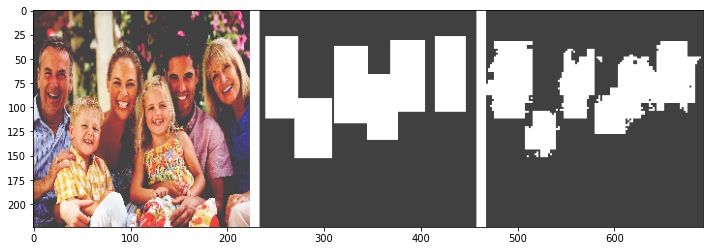

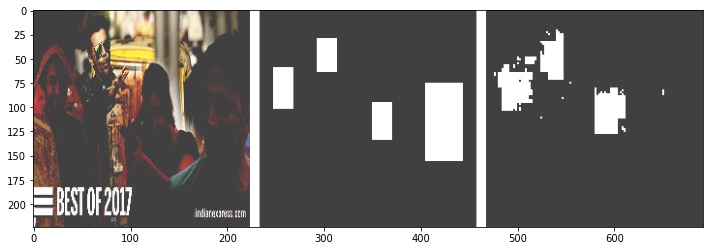

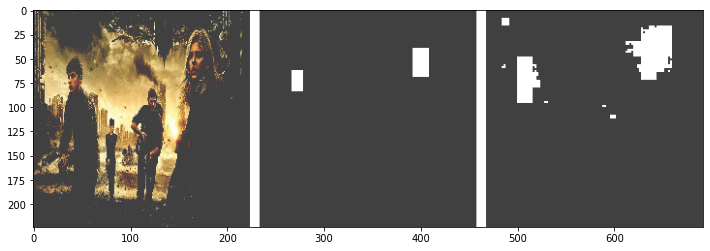

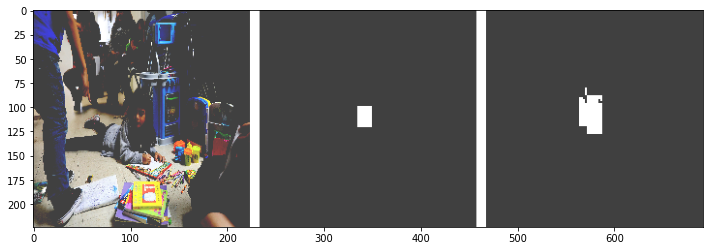

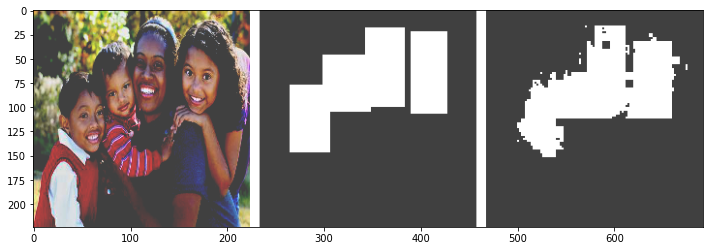

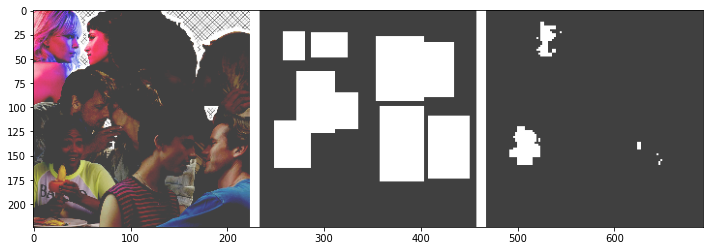

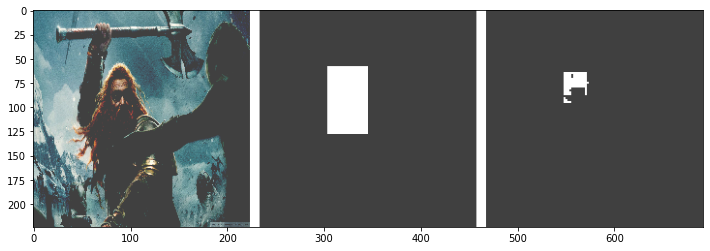

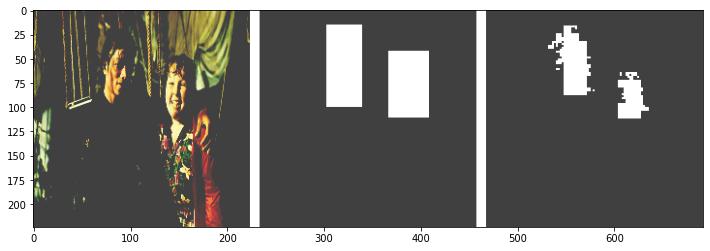

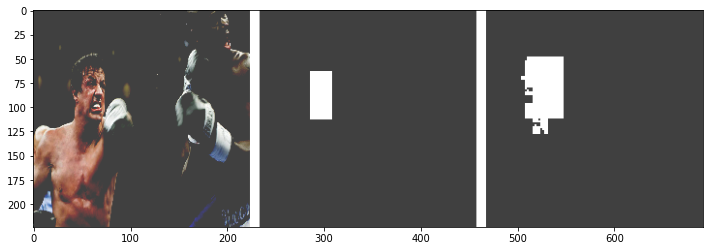

In [ ]:
for i, (x, y) in enumerate(zip(X_test, y_test)):
    y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
    h, w, _ = x.shape
    white_line = np.ones((h, 10, 3))

    all_images = [
        x, white_line,
        mask_parse(y), white_line,
        mask_parse(y_pred)
    ]
    image = np.concatenate(all_images, axis=1)
    
    fig = plt.figure(figsize=(12, 12))
    a = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(image,alpha=0.75)